In [4]:
import os

HOME = os.getcwd()
CONFIG_PATH = os.path.abspath("/Users/tiger/Documents/Github/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))
WEIGHTS_PATH = os.path.abspath("/Users/tiger/Documents/Github/GroundingDINO/weights/groundingdino_swint_ogc.pth")
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/Users/tiger/Documents/Github/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/Users/tiger/Documents/Github/GroundingDINO/weights/groundingdino_swint_ogc.pth ; exist: True


In [12]:
from groundingdino.util.inference import load_model, predict, annotate
model = load_model(CONFIG_PATH, WEIGHTS_PATH)

final text_encoder_type: bert-base-uncased


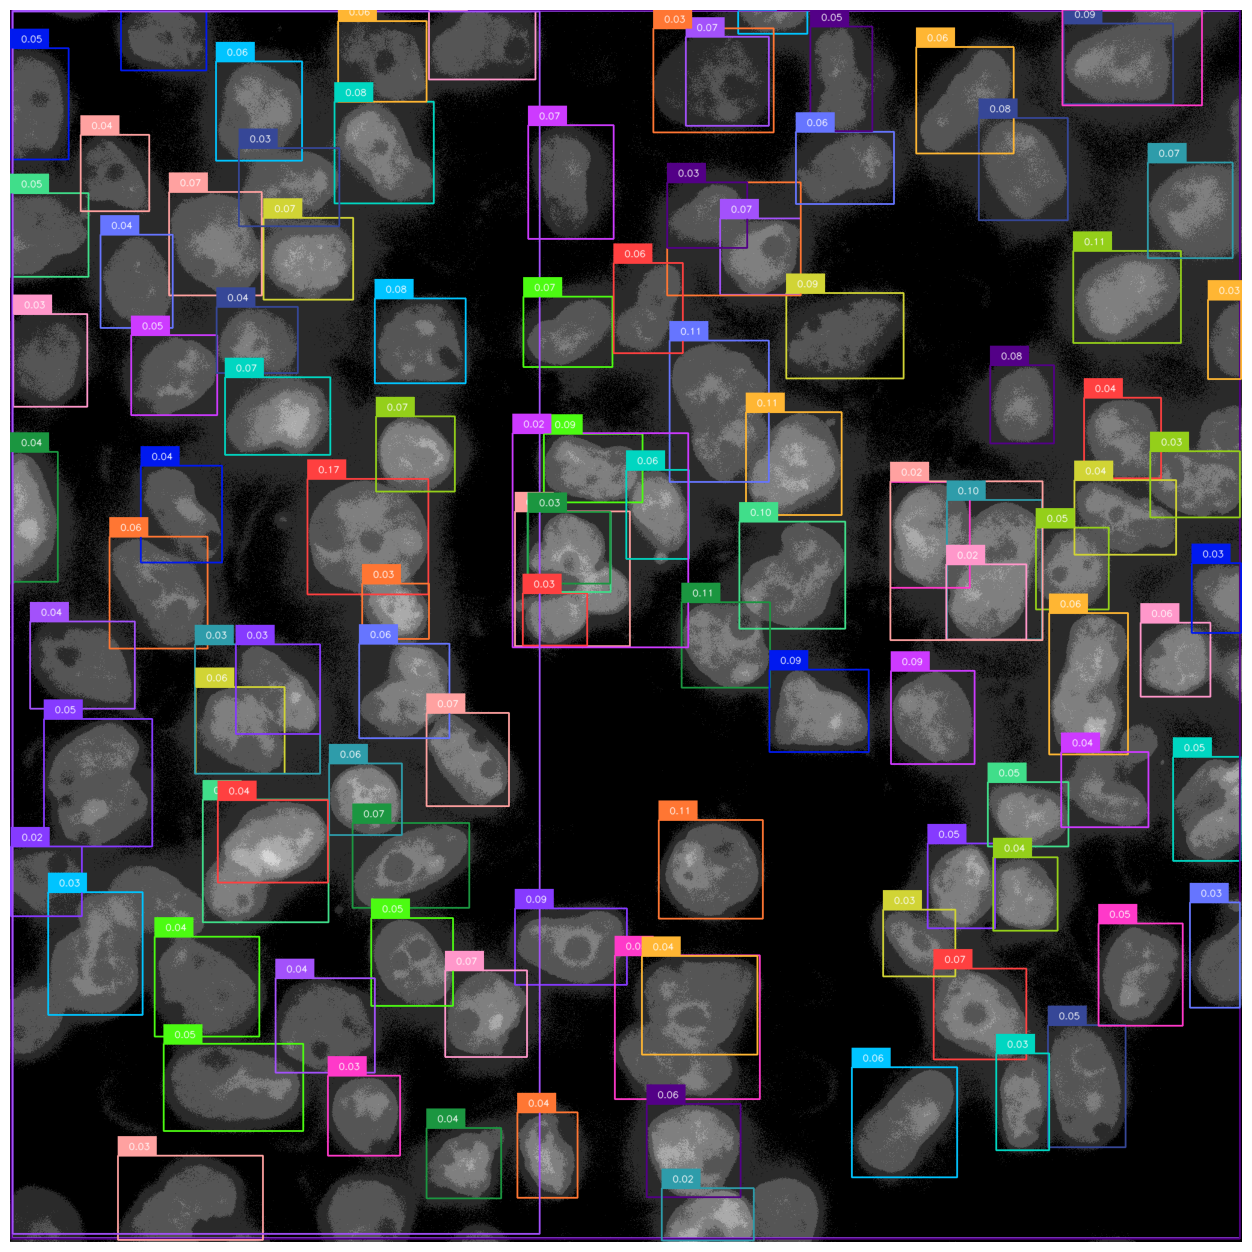

In [85]:
from datasets import Dataset
import numpy as np
import torch
import groundingdino.datasets.transforms as T
from typing import Tuple, List
from PIL import Image
import supervision as sv

def load_image(img: np.ndarray) -> Tuple[np.array, torch.Tensor]:
    def grayscale_to_rgb(grayscale_img) -> np.ndarray:
        rgb_img = np.zeros((2048, 2048, 3), dtype=np.uint8)
        img_uint8 = np.clip(grayscale_img//256, 0, 255).astype(np.uint8)
        rgb_img[:, :, 0] = img_uint8
        rgb_img[:, :, 1] = img_uint8
        rgb_img[:, :, 2] = img_uint8
        dynamic_exp_factor = 255.0 / np.max(rgb_img[:, :, 0])
        brightened_image = np.clip(rgb_img * dynamic_exp_factor, 0, 255).astype(np.uint8)
        return brightened_image
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image_source = Image.fromarray(grayscale_to_rgb(img))
    image = np.asarray(image_source)
    image_transformed, _ = transform(image_source, None)
    return image, image_transformed



dataset = Dataset.load_from_disk("./assets/dataset/")
img = np.array(dataset[100]["image"])
image_source, image = load_image(img)

TEXT_PROMPT = "white flower"
BOX_TRESHOLD = 0.02
TEXT_TRESHOLD = 0.25

boxes, logits, phrases = predict(
    model=model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD,
    device="cpu"
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline 
sv.plot_image(annotated_frame, (16, 16))